<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()



In [3]:
import pandas as pd
data=pd.read_csv('D:\DeTaiNam2024\SoLieuHong\ACB.csv')
data.head

<bound method NDFrame.head of       Unnamed: 0       time   open   high    low  close    volume
0              0   5/1/2015   2.82   2.82   2.78   2.80     55888
1              1   6/1/2015   2.78   2.84   2.76   2.84     89802
2              2   7/1/2015   2.84   2.93   2.84   2.87    232861
3              3   8/1/2015   2.87   2.89   2.85   2.89     14880
4              4   9/1/2015   2.89   2.98   2.85   2.91    693623
...          ...        ...    ...    ...    ...    ...       ...
2354        2354  17/6/2024  24.60  24.60  24.25  24.55   6375848
2355        2355  18/6/2024  24.70  24.70  24.40  24.55   5729760
2356        2356  19/6/2024  24.55  24.70  24.25  24.65   7618993
2357        2357  20/6/2024  24.55  24.85  24.40  24.80  10178313
2358        2358  21/6/2024  24.85  24.85  24.50  24.55   5126289

[2359 rows x 7 columns]>

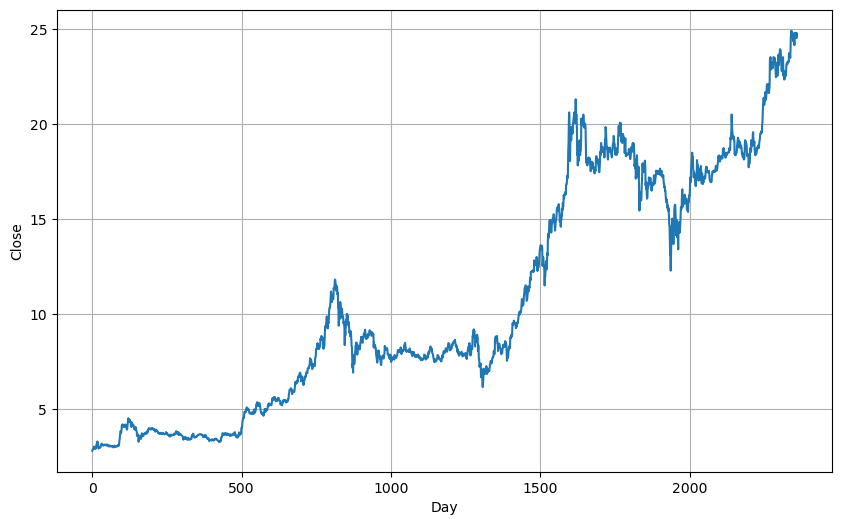

In [4]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieuHong\ACB.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[5]))

# Convert lists to numpy arrays
time_step = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time_step, series, xlabel='Day', ylabel='Close')

In [5]:
# Define the split time
split_time = 2000

# Get the train set 
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 500
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)


Epoch 1/100
62/62 [==============================] - 17s 110ms/step - loss: 3.2386 - mae: 3.6831
Epoch 2/100
62/62 [==============================] - 1s 17ms/step - loss: 1.0051 - mae: 1.4176
Epoch 3/100
62/62 [==============================] - 1s 16ms/step - loss: 0.8980 - mae: 1.3088
Epoch 4/100
62/62 [==============================] - 1s 15ms/step - loss: 0.7303 - mae: 1.1248
Epoch 5/100
62/62 [==============================] - 1s 16ms/step - loss: 0.6508 - mae: 1.0375
Epoch 6/100
62/62 [==============================] - 1s 16ms/step - loss: 0.5484 - mae: 0.9226
Epoch 7/100
62/62 [==============================] - 1s 15ms/step - loss: 0.4882 - mae: 0.8562
Epoch 8/100
62/62 [==============================] - 1s 15ms/step - loss: 0.3985 - mae: 0.7447
Epoch 9/100
62/62 [==============================] - 1s 15ms/step - loss: 0.3373 - mae: 0.6629
Epoch 10/100
62/62 [==============================] - 1s 16ms/step - loss: 0.2809 - mae: 0.5910
Epoch 11/100
62/62 [===========================

62/62 [==============================] - 1s 20ms/step - loss: 0.0668 - mae: 0.2680
Epoch 87/100
62/62 [==============================] - 1s 19ms/step - loss: 0.0698 - mae: 0.2756
Epoch 88/100
62/62 [==============================] - 2s 24ms/step - loss: 0.0750 - mae: 0.2869
Epoch 89/100
62/62 [==============================] - 1s 21ms/step - loss: 0.0669 - mae: 0.2671
Epoch 90/100
62/62 [==============================] - 1s 17ms/step - loss: 0.0737 - mae: 0.2869
Epoch 91/100
62/62 [==============================] - 2s 22ms/step - loss: 0.0681 - mae: 0.2718
Epoch 92/100
62/62 [==============================] - 2s 24ms/step - loss: 0.0636 - mae: 0.2592
Epoch 93/100
62/62 [==============================] - 2s 23ms/step - loss: 0.0668 - mae: 0.2682
Epoch 94/100
62/62 [==============================] - 1s 19ms/step - loss: 0.0663 - mae: 0.2693
Epoch 95/100
62/62 [==============================] - 1s 18ms/step - loss: 0.0675 - mae: 0.2707
Epoch 96/100
62/62 [==============================] -

In [7]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

12/12 [==============================] - 2s 18ms/step


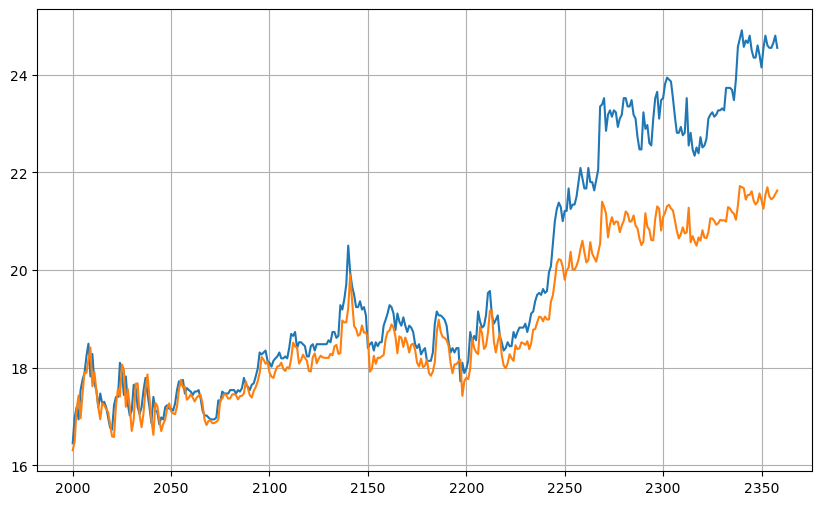

[16.307293 16.48299  17.157259 17.429216 16.96373  17.462135 17.904558
 17.89178  18.162642 18.411308 17.618729 17.91267  17.55709  17.188286
 16.945147 17.27307  17.231876 17.15193  17.09146  16.836279 16.590979
 16.581251 17.232504 17.565298 17.407093 18.06517  17.960442 17.19814
 17.560604 17.19479  16.703358 16.934324 17.67289  17.677439 17.02731
 16.781048 17.070475 17.574732 17.86089  17.40579  16.92769  16.622303
 17.276058 17.214495 16.929064 16.700933 16.844597 16.937366 17.171125
 17.267725 17.106268 17.063404 17.047247 17.200712 17.552473 17.75135
 17.593822 17.611156 17.343107 17.384007 17.452505 17.386923 17.306585
 17.385302 17.428215 17.44092  17.25293  16.929125 16.824776 16.908508
 16.915966 16.862902 16.866812 16.887955 16.93919  17.341358 17.367596
 17.457886 17.44389  17.366396 17.368437 17.448668 17.458979 17.432013
 17.350424 17.41529  17.422615 17.471869 17.71771  17.580214 17.433102
 17.387527 17.521135 17.600021 17.718487 17.893354 18.217867 18.16174
 18.079481

In [8]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
print(results)
# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)